In [ ]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import pickle
import time
import dask.dataframe as dskdf
import dask
gl = globals()

def taken_time(word):
    taken = time.time() - start
    h = int(taken/60/60)
    m = int(taken/60%60)
    s = int(taken%60%60)
    print("it takes "+str(h)+"h"+str(m)+"m"+str(s)+"s to finish "+word)
    

class rawdata:
    #地域系は全部で４つのデータをマージする
    #車種系は全部で●つのデーたをマージする
    #車種の元ネタが成約データなので、最終的に車種データに地域データを市区町村名で紐付ける

    #地域(1)
    #市区町村別国勢調査
    def make_kokusei(self):
        self.kokusei = pd.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/kokuseichosa_2015_for_merge.csv",nrows=10000)
        #全てを英字変換する必要あり
        self.kokusei.columns=["pref_code", "pref_city_code", "capital_city_flg", "city_categories", "chiho", "city_name",
                         "population", "h22_kumikae_population", "population_changed_from_h22_to_h27", "rate_population_changed_from_h22_to_h27",
                         "gross_area", "population_density", "ave_age_from_h22_to_h27", "med_age_from_h22_to_h27", "population",
                         "population_under_15old", "population_from_15_to_64_old", "population_over_65old", "rate_population_under_15_year_old",
                         "rate_population_from_15_to_64_old", "rate_population_over_65old", "population_male","population_male_under_15old",
                         "population_male_from_15_to_64_old", "population_male_over_65old", "rate_population_male_under_15old",
                         "rate_population_male_from_15_to_64_old", "rate_population_male_over_65old", "population_female",
                         "population_female_under_15old", "population_female_from_15_to_64_old", "population_female_over_65old",
                         "rate_population_female_under_15old", "rate_population_female_from_15_to_64_old", "rate_population_female_over_65old",
                         "rate_population_male_to female", "population_jap", "population_no_jap", "num_of_family", "num_of_normal_family",
                         "num_of_family_in_facilities", "h22_kumikae_family", "num_of_normal_family", "num_of_nuclear_family",
                         "num_of_family_no_children", "num_of_family_with_children", "num_of_father_and_children", "num_of_mother_and_children",
                         "num_of_singles", "num_of_over_65old_singles", "num_of_old_married_couples_no_children", "num_of_3generation_family",]
        return self.kokusei

    #chiho(都道府県名)で国勢調査と保有台数をマージ
    def left_merge_on_chiho(self,left,right,out):
        out = pd.merge(left,right,on="chiho",how="left")
        #一番下に謎の欠損行が存在するので削除する
        out = out.dropna(subset=['pref_code'])
        return out

    #地域(2)
    #都道府県別保有台数
    def make_hoyu(self):
        hoyu = pd.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/2015_hoyu_daisu.csv",encoding="utf-8",nrows=10000)
        hoyu.columns = ["chiho", "num_of_cars_all", "num_of_cars_kei", "num_of_cars_normal", "num_of_familiy", "cars_per_person",
                        "normal_cars_per_person", "kei_cars_per_person", "kei_rate", "normal_rate", "kei_share_in_JP", "normal_share_in_JP",
                        "guess_2nd_hand_kei_car_sales_per_year", "guess_2nd_hand_normal_car_sales_per_year", "guess_2nd_hand_car_all_sales_per_year"]
        self.koku_hoyu = self.left_merge_on_chiho(self.kokusei, hoyu, "self.koku_hoyu")
        return self.koku_hoyu


    #car_sensor在庫/見積問い合わせの大元データ作成
    def make_toiawase(self):
        # self.kuruma = pd.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/物件*問い合わせ/tes.csv")
        ku = pd.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/物件*問い合わせ/toiawase_1.csv",
                         delimiter="\t", dtype="object", encoding="cp932",nrows=10000)
        ru = pd.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/物件*問い合わせ/toiawase_2.csv",
                         delimiter="\t", dtype="object", encoding="cp932",names=ku.columns,nrows=10000)
        ma = pd.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/物件*問い合わせ/toiawase_3.csv",
                         delimiter="\t", dtype="object", encoding="cp932",names=ku.columns,nrows=10000)
        kuru = pd.concat([ku,ru],axis=0)
        self.kuruma = pd.concat([kuru,ma],axis=0)
        #表記の統一
        self.kuruma["b.shikuchoson_jusho_kj"] = self.kuruma["b.shikuchoson_jusho_kj"].str.replace('ヶ', 'ケ')
        #前後スペースの削除
        self.kuruma["b.todofuken_jusho_kj"] = self.kuruma["b.todofuken_jusho_kj"].map(lambda x: str(x).strip())
        # 都道府県欠損を削除
        self.kuruma = self.kuruma.dropna(subset=["b.todofuken_jusho_kj"])
        # 都道府県名に異常値が入っているものを除く
        # '〓','null','nan'が入っていたら削除
        self.kuruma = self.kuruma.ix[self.kuruma['b.todofuken_jusho_kj'] != "〓"]
        self.kuruma = self.kuruma.ix[self.kuruma['b.todofuken_jusho_kj'] != "null"]
        self.kuruma = self.kuruma.ix[self.kuruma['b.todofuken_jusho_kj'] != "nan"]

        #県単位、市区町村単位での地方別集計（問い合わせ）
        #もともとの市区町村名に入ってるレベル感が違う(市区町村で終わるものもあれば、町大字まで入っているものもある)
        #市区町村マスタと一致する部分のみ残す
        dl = pd.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/市区町村マスタ.csv",names=["pref","city"],nrows=10000)

        #h市区町村表記揺れを消したい
        dl["city"] = dl["city"].str.replace('ヶ', 'ケ')
        pre = dl["pref"].unique() #array
        #県内市区町村数のカウント用
        dl["count"] =1
        num = dl.groupby("pref").sum()
        dc = num.to_dict()
        dic = dc["count"]

        biglis = []
        c=0
        #都道府県別市区町村の格納
        for i in pre:
            tmplis = []
            for k in range(int(dic[i])):
        #             exec("tmplis.append(dl['city']["+str(c)+"])")
                tmplis.append(dl['city'][c])
                c +=1
            #元データの入り方が札幌市→札幌市〇〇区、といった順で入っているので、上から部分一致で合致を探す際の障害になる
            #ゆえに最初の要素を最後に持ってくる処理が必要
            push_to_last = tmplis.pop(0)
            tmplis.append(push_to_last)
            biglis.append(tmplis)

        #辞書の作成
        #県名をキーとして、市区町村名のリストをバリューとする
        dicts = {key: value for (key, value) in zip(pre,biglis)}

        #dfの各要素について、辞書のどこに一致するかを見て、ループで部分一致を探す
        #部分一致したものをtoshiで保持する
        ken = self.kuruma["b.todofuken_jusho_kj"].values
        org_toshi = self.kuruma["b.shikuchoson_jusho_kj"].values
        toshi = [] #整形した市区町村名
        counter =[] #部分一致するものがあるかどうかのフラグ
        for k,i in zip(ken,org_toshi):
            count=0
            for l in dicts[k]:
                if l in i:
                    toshi.append(l)
                    counter.append(1)
                    break
                count+=1
                if count >=(len(dicts[k])):
                    toshi.append("")
                    counter.append(0)
                    break
        #概ねOKだけど、県名の後に直接郡の名前が来るケースに対応できていない
        # →修正面倒なので後回し
        #スクレイピングで持ってくる必要ある：　http://www.geocities.jp/je2kcr/current_allgun.htm
        #toshiが欠損のものはとりあえず除外検討

        #bbをkurumaにマージ
        self.kuruma["city_name"] = toshi
        self.kuruma["count"] = 1
        #toiawase_dateの型を日付型に変更する必要がある
        self.kuruma["toiawase_datetime"] = pd.to_datetime(self.kuruma["b.toiawase_date"].str[:10] + " " + self.kuruma["b.toiawase_date"].str[10:])
        self.kuruma["toiawase_y"] = self.kuruma["toiawase_datetime"].dt.year.astype(str)
        self.kuruma["toiawase_m"] = self.kuruma["toiawase_datetime"].dt.month.astype(str)
        self.kuruma["toiawase_ym"] = self.kuruma["toiawase_y"] + self.kuruma["toiawase_m"]
        return self.kuruma

    # 地域別集計(問い合わせ)
    # 全て辞書形式で持っておいて、実際の車に紐付ける形にする
    # 実際の元データの車種名、地域、スペックと紐付けたドア数をキーにして辞書から値を作成する
    def convert_to_unit_based_num(self, data, colname, indice):
        out = data.reset_index().pivot(index=indice, columns=colname, values="count")
        vals = []
        # 異常値の除去
        for i in out.columns:
            vals.append(out.columns.name + "_" + str(i))
        out.columns = vals
        out[indice] = out.index
        del out.index.name

        return out

    #地域(3)
    #問い合わせの地域別集計
    def toiawase_shukei_area(self):
        #都道府県
        pref_summary = self.kuruma.groupby("b.todofuken_jusho_kj").sum()["count"]
        pref_summary_dicts = {key: value for (key, value) in zip(pref_summary.index.values,pref_summary.values)}
        self.kuruma["num_toiawase_in_pref"] = self.kuruma["b.todofuken_jusho_kj"].apply(pref_summary_dicts.get)

        #市区町村
        city_summary = self.kuruma.groupby("city_name").sum()["count"]
        city_summary_dicts = {key: value for (key, value) in zip(city_summary.index.values,city_summary.values)}
        self.kuruma["num_toiawase_in_city"] = self.kuruma["city_name"].apply(city_summary_dicts.get)

        #都道府県/市区町村単位でボディタイプ、問合年月、ドア数で集計（計６パターン）
        shukei_val = ["a.body_type_name", "toiawase_ym", "a.door_su"]
        out_name = ["body", "month", "door",]

        pref_city = ["b.todofuken_jusho_kj","city_name"]
        out_preposition = ["pref", "city"]

        for s,o in zip(shukei_val,out_name):
            for p,op in zip(pref_city,out_preposition):
                su = str(op)+'_'+str(o)+'_summary' #中間df名
                sud = str(op)+'_'+str(o)+'_summary_dicts' #辞書名
                va = 'num_toiawase_'+str(o)+'_in_'+str(p) #変数名
                df2 = o+'_by_'+op #最終df名

                gl[su] = self.kuruma.groupby([p,s]).sum()["count"]
                gl[sud] = {key: value for key, value in zip(gl[su].index.values,gl[su].values)} #辞書に格納
                self.kuruma[va] = self.kuruma.apply(lambda x :gl[sud].get((x[p],x[s])), 1) #変数を問い合わせに追加
                gl[df2] = self.convert_to_unit_based_num(gl[su],s,p) #県別/市区町村別でテーブル作成

        #出来上がったデータセットをすべてくっつける
        cities = [body_by_city, door_by_city, month_by_city]
        prefs = [body_by_pref, door_by_pref, month_by_pref]

        #prefsの変数名を変更しておく必要がある
        #遅いと思われるけど、シンプルさを優先した
        for c in cities:
            self.koku_hoyu = pd.merge(self.koku_hoyu,c,on="city_name")
        for p in prefs:
            p = p.rename(columns={"b.todofuken_jusho_kj":"chiho"})
            self.koku_hoyu = pd.merge(self.koku_hoyu,p,on="chiho")

        self.koku_hoyu_area = self.koku_hoyu.copy()
        return self.koku_hoyu_area

    #車種(1)
    #車種・グレード別集計（問い合わせ）
    def toiawase_shukei_shashu(self):
        #body_typeごと
        body_summary = self.kuruma.groupby("a.body_type_name").sum()["count"]
        body_summary_dicts = {key: value for (key, value) in zip(body_summary.index.values,body_summary.values)}
        self.kuruma["num_body_type"] = self.kuruma["a.body_type_name"].apply(body_summary_dicts.get)
        # -車種ごと
        shashu_summary = self.kuruma.groupby("a.keisai_shashu_kj").sum()["count"]
        shashu_summary_dicts = {key: value for (key, value) in zip(shashu_summary.index.values,shashu_summary.values)}
        self.kuruma["num_shashu"] = self.kuruma["a.keisai_shashu_kj"].apply(shashu_summary_dicts.get)
        # -車種&FMCごと
        shashu_fmc_summary = self.kuruma.groupby(["a.keisai_shashu_kj","a.keisai_fmc_cd"]).sum()["count"]
        shashu_fmc_summary_dicts = {key: value for (key, value) in zip(shashu_fmc_summary.index.values,shashu_fmc_summary.values)}
        self.kuruma["num_shashu_fmc"] = self.kuruma.apply(lambda x :shashu_fmc_summary_dicts.get((x["a.keisai_shashu_kj"],x["a.keisai_fmc_cd"])), 1)
        # fmc_by_shashu = self.convert_to_unit_based_num(shashu_fmc_summary,"a.keisai_shashu_kj","a.keisai_fmc_cd")

        #要修正＿済み
        # -車種&FMC&MCごと
        shashu_fmc_mc_summary = self.kuruma.groupby(["a.keisai_shashu_kj","a.keisai_fmc_cd","a.keisai_mc_cd"]).sum()["count"]
        shashu_fmc_mc_summary_dicts = {key: value for (key, value) in zip(shashu_fmc_mc_summary.index.values,shashu_fmc_mc_summary.values)}
        self.kuruma["num_shashu_fmc_mc"] = self.kuruma.apply(lambda x :shashu_fmc_mc_summary_dicts.get((x["a.keisai_shashu_kj"],x["a.keisai_fmc_cd"],x["a.keisai_mc_cd"])), 1)
        # fmc_mc_by_shashu = self.convert_to_unit_based_num(shashu_fmc_mc_summary,"a.keisai_shashu_kj",["a.keisai_fmc_cd","a.keisai_mc_cd"])
        # -車種&FMC&MC&グレードごと
        shashu_fmc_mc_grade_summary = self.kuruma.groupby(["a.keisai_shashu_kj","a.keisai_fmc_cd","a.keisai_mc_cd","a.keisai_haikiryo_grade_cd"]).sum()["count"]
        shashu_fmc_mc_grade_summary_dicts = {key: value for (key, value) in zip(shashu_fmc_mc_grade_summary.index.values,shashu_fmc_mc_grade_summary.values)}
        self.kuruma["num_shashu_fmc_mc_grade"] = self.kuruma.apply(lambda x :shashu_fmc_mc_grade_summary_dicts.get((x["a.keisai_shashu_kj"],x["a.keisai_fmc_cd"],x["a.keisai_mc_cd"],x["a.keisai_haikiryo_grade_cd"])), 1)
        # grade_fmc_mc_by_shashu = self.convert_to_unit_based_num(shashu_fmc_mc_grade_summary,"a.keisai_shashu_kj","a.keisai_fmc_cd","a.keisai_mc_cd","a.keisai_grade_name")

        #車種・グレード別集計（お気に入り）
        #地域みたいにまとめることができないので、個別のDFを吐き出しておく
        return [body_summary, shashu_summary, shashu_fmc_summary, shashu_fmc_mc_summary, shashu_fmc_mc_grade_summary]
        # return [body_summary, shashu_summary, shashu_fmc_summary]


    #地域(4)
    #カスタマDBの作成
    def summarize_cusdb(self):
        cus = pd.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/cusdb_all.csv",nrows=10000)
        # 予測含め、地域が入ってないものを捨てる
        # 予測精度約７割程度はあるので、まあいいかなと
        city_drop_na = cus.dropna(subset=['pref_integration_cd'])
        # 実際のデータセットはpref_integration_nmで作成する


        tmp_dt = city_drop_na.ix[:, ["count", "have_child_integration_flg",
                                     "pref_integration_nm"]].groupby(
            ["pref_integration_nm", "have_child_integration_flg"]).sum()
        # 県別にフラグの値をカウント
        merged = tmp_dt.reset_index().pivot(index=tmp_dt.index.names[0], columns=tmp_dt.index.names[1], values="count")
        lis = []
        for i in merged.columns:
            lis.append(str(merged.columns.name) + "_" + str(i))
        merged.columns = lis
        del merged.index.name
        merged["pref"] = merged.index
        # merged.head()

        # 変数を動的に与えて、ループでデータセットを作成＆append
        # フラグ系対象変数
        # sp系は数値が入っていないので、最初は抜いて試す
        # iter_target = ["sex_integration", "age_integration_cd", "high_income_predict_flg",
        #                "businessperson_integration_flg", "couple_flg", "have_baby_flg", "car_1w_pv_flg", "car_1m_pv_flg", "car_3m_pv_flg",
        #                "car_6m_pv_flg", "car_12m_pv_flg", "sp_holiday_flg", "sp_weekday_flg", "pc_holiday_flg", "pc_weekday_flg", "holiday_flg",
        #                "weekday_flg", "sp_holiday_time_seg", "sp_weekday_time_seg", "pc_holiday_time_seg", "pc_weekday_time_seg",
        #                "holiday_time_seg", "weekday_time_seg", "weekday_device_seg"]
        iter_target = ["sex_integration", "age_integration_cd", "high_income_predict_flg",
                       "businessperson_integration_flg", "couple_flg", "have_baby_flg", "car_1w_pv_flg", "car_1m_pv_flg",
                       "car_3m_pv_flg", "car_6m_pv_flg", "car_12m_pv_flg"]

        loop_count = 0
        for i in iter_target:
            loop_count += 1
            tmp_dt = city_drop_na.ix[:, ["count", str(i), "pref_integration_nm"]].groupby(
                ["pref_integration_nm", str(i)]).sum()
            #         exec('tmp_dt = city_drop_na.ix[:,["count","'+str(i)+'","pref_integration_nm"]].groupby(["pref_integration_nm","'+str(i)+'"]).sum()')
            # 県別にフラグの値をカウント
            tmp = tmp_dt.reset_index().pivot(index=tmp_dt.index.names[0], columns=tmp_dt.index.names[1], values="count")
            tmp_rate = tmp.copy() / len(city_drop_na)
            # 一時対応策：カラム名が同一になってしまい、後で不都合が起こるので、一時的に適当なカラム名を与える
            tmp_lis = (np.array(list(range(len(tmp_rate.T)))) + 1) * 10
            tmp_rate.columns = tmp_lis

            lis = []
            for n in range(2):
                for i in tmp.columns:
                    if n == 0:
                        lis.append(str(tmp.columns.name) + "_" + str(i))
                    if n == 1:
                        lis.append(str(tmp.columns.name) + "_" + str(i) + "_rate")

            tmp = pd.concat([tmp, tmp_rate], axis=1)
            tmp.columns = lis
            del tmp.index.name
            tmp["pref"] = tmp.index
            # 率も入れる

            # できたものを元のデータセットにマージしていく
            merged = pd.merge(merged, tmp, on="pref")
        # if loop_count >=11:
        #         break

        # 数値系の統合(年収、年齢：平均、中央値)
        num_loop = ["annual_income_predict_value", "annual_income_integration_cd", "age_integration_value"]

        for l in num_loop:
            tmp_mean = city_drop_na.ix[:, [str(l), "pref_integration_nm"]].groupby(["pref_integration_nm"]).mean()
            tmp_med = city_drop_na.ix[:, [str(l), "pref_integration_nm"]].groupby(["pref_integration_nm"]).median()
            tmp_mean.columns = [str(l) + "_mean"]
            tmp_med.columns = [str(l) + "_med"]
            tmp_mean["pref"] = tmp_mean.index
            tmp_med["pref"] = tmp_med.index
            merged = pd.merge(merged, tmp_mean, on="pref")
            merged = pd.merge(merged, tmp_med, on="pref")

            cus_extracted = merged.copy()
            cus_extracted = cus_extracted.rename(columns={"pref": "chiho"})

            # 最後に市区町村単位にサマッたカスタマDBを民力にマージする
            self.koku_hoyu_area_cusdb = pd.merge(self.koku_hoyu_area, cus_extracted, on="chiho")

            return self.koku_hoyu_area_cusdb



    #大元データ
    #お気に入り＆成約データ読み込み
    #お気に入りデータだけだと成立しないので、先んじて成約データとのマージをしておく必要がある
    def make_seiyaku(self):
        #成約データ
        #要修正
        #本番はdaskで読む必要あると思われるのでそうする
        #self.seiyaku = pd.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/raw_data.csv",delimiter=" ",nrows=10000)
        self.seiyaku = dskdf.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/org_seiyaku.csv",delimiter=" ").head(n=10000)

        #きちんとテストする際に全量で実施する必要あり

        #お気に入りデータ
        col = ["wns_bukken_cd", "shinkoyo_nohimbi_cd", "han_cd", "hojin_cd", "madoguchi_cd", "sum_toiawase",
               "base_plan_toiawase", "plan1_toiawase", "plan2_toiawase", "cart_add", "cart_delete"]
        #dask使わないと遅すぎて無理
        start = time.time()
        tes1 = dskdf.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/favorite/001.csv",names=col).head(n=10000)
        tes2 = dskdf.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/favorite/002.csv",names=col).head(n=10000)
        tes3 = dskdf.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/favorite/003.csv",names=col).head(n=10000)
        tes4 = dskdf.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/favorite/004.csv",names=col).head(n=10000)
        tes5 = dskdf.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/favorite/005.csv",names=col).head(n=10000)

        t1 = tes1.append(tes2)
        t2 = t1.append(tes3)
        t3 = t2.append(tes4)
        t4 = t3.append(tes5)

        fav = t4.loc[:,["wns_bukken_cd", "shinkoyo_nohimbi_cd", "sum_toiawase", "cart_add", "cart_delete"]]

        # データが多すぎて先に車種単位にまとめないと処理不可能
        #物件tblからデータを抜いてきて（wns_bukken_cd,車種名、車種に関連するものだけ）突合、groupbyで車種ごとにサマるところからスタート
        tobe = self.seiyaku.ix[:,["wns_bukken_cd", "shashu", "grade_cd", "grade_kukuri_cd", "body_type_cd", "body_type_name"]]
        #rightはpandas DataFrameじゃないと何故か上手くいかない・・・
        self.bukken = fav.merge(tobe,how="inner",on="wns_bukken_cd")
        self.bukken["count"]=1

        return [self.seiyaku, self.bukken]

    #車種(2)
    #車種別全期間(直近３年間)お気に入り数集計
    def okini_shukei_zenkikan(self):
        #全体のお気に入り数を出す
        zentai = self.bukken.groupby(["shashu","grade_cd"]).sum()
        self.okini_zen = zentai.reset_index()
        self.okini_zen["shinkoyo_nohimbi_cd"] = "all"
        self.okini_zen["cart_sum"] = self.okini_zen["cart_add"] - self.okini_zen["cart_delete"]

        return self.okini_zen

    #車種(2.5)
    #車種別期間別(特定の１年間)お気に入り数集計
    # 死ぬほど時間かかるので、今回は飛ばしでいいかも
    def okini_shukei_kikanbetsu(self):
        # 期間を絞って（１年分、１ヶ月単位）お気に入り数の遷移を見る
        # 最終的には車種、グレード、nohimbiをキーとした辞書を作成し、車種ごとのお気に入り数を当てる感じになる
        # shashuとgrade_cdでgroupbyする
        sam = self.bukken.groupby(["shashu", "grade_cd", "shinkoyo_nohimbi_cd"]).sum()
        # 元テーブルとして使う
        samr = sam.reset_index()
        # shinkoyo_nohinbiが特定日付区間に入っているものだけを抜き出して、groupby(shashu,grade_cd)で処理する
        upper_date = 151030
        # upper_dateが100ずつ足されていく感じ
        # dataframeに入ってる最終日を超えたら処理中断
        # limit = int(t5["shinkoyo_nohimbi_cd"][len(t5)-1])
        limit = int(t5["shinkoyo_nohimbi_cd"].tail().iloc[4])
        loop_count = 0

        while upper_date <= limit:
            lower = samr[samr["shinkoyo_nohimbi_cd"] > (upper_date - 10000)]
            lowup = lower[lower["shinkoyo_nohimbi_cd"] <= upper_date]

            # 日付を絞ってループで回す
            if len(lowup) > 0:
                smpl = lowup
            else:
                pass

            # 実際の集計
            part = smpl.groupby(["shashu", "grade_cd"]).sum()
            datum = part.reset_index()
            # 変数名の加工

            dt = str(smpl["shinkoyo_nohimbi_cd"].tail().iloc[4])
            col_list = ["sum_toiawase", "cart_add", "cart_delete", "count"]
            new_col = ["shashu", "grade_cd", "shinkoyo_nohimbi_cd"]
            for k in col_list:
                new_col.append("from_" + str(dt) + "_1y_back_" + k)

            datum.columns = new_col
            datum = datum.drop("shinkoyo_nohimbi_cd", axis=1)
            datum = datum.drop("count", axis=1)
            datum["favorite"] = datum["cart_add"] - datum["cart_delete"]
            upper_date += 100
            if int(upper_date / 100 % 100) == 13:
                upper_date = upper_date + 8700  # 年を更新する処理

            # 初回ループでなければデータをマージしていく
            # 要修正
            # マージでなくて、shinkoyo_nohimbi_cdの違うものが縦に積みあがるケースも考慮すべき

            if loop_count != 0:
                #         okini.merge(datum,on=["shashu","grade_cd"])
                self.okini_kikan.merge(datum, how="outer", on=["shashu", "grade_cd"], )
            else:
                self.okini_kikan = datum
            loop_count += 1

        # if loop_count >2:
        #         break

        # あとはこれをshashu,grade_cdで横に繋げていく(merge)
        # 一番重い処理なので、回さないほうがいいかも
        return self.okini_kikan


    #車種(3)
    #カタログデータ（車種別/モデル別スペック表）の作成
    # 全部で21種あるので、全て読み込んだ後にカタログデータを１つにまとめる
    #データ量が非常に大きいので、daskで処理させる必要あり

    def make_catalogue(self):
        cat_list = ["mc1_body_type.txt", "mc1_kanren_shashu.txt", "mc1_brand.txt", "mc1_kihon_iro.txt",
                    "mc1_brand_country.txt",
                    "mc1_kukuri_kanren_shashu.txt", "mc1_brand_iro.txt", "mc1_maker.txt", "mc1_brand_maker.txt",
                    "mc1_mc_model.txt",
                    "mc1_country.txt", "mc1_mc_model_gazo.txt", "mc1_fmc_model.txt", "mc1_net_category.txt",
                    "mc1_fp_shashu_midashi_settei_work.txt", "mc1_shashu.txt", "mc1_grade.txt", "mc1_sobi.txt",
                    "mc1_grade_iro.txt",
                    "mc1_transmission_henkan.txt", "mc1_grade_sobi.txt"]
        index_name = ["ボディ形状マスタ", "関連車種マスタ", "ブランドマスタ", "基本色マスタ", "ブランド国設定マスタ", "括り関連車種マスタ",
                      "ブランド色マスタ", "メーカーマスタ", "ブランドメーカー設定マスタ", "MCモデルマスタ", "国マスタ", "MCモデル画像マスタ",
                      "FMCモデルマスタ", "NETカテゴリマスタ", "FP車種見出し設定マスタ", "車種マスタ", "グレードマスタ", "装備マスタ",
                      "グレード色設定マスタ", "トランスミッション変換マスタ", "グレード装備設定マスタ", ]
        df_columns = [["body_shape_cd", "body_shape_nm", "register_ymd", "last_modified_ymd"],
                      ["kanren_shashu_cate", "kanren_shashu_cate_no", "kanren_kj", "register_ymd", "last_modified_ymd"],
                      ["brand_cd", "brand_nm", "brand_hyoji_order", "catalogue_keisai_fuka_cate", "seo_folder_nm",
                       "register_ymd", "last_modified_ymd"],
                      ["base_color_cd", "base_color_nm", "base_color_hyoji_jun", "register_ymd", "last_modified_ymd"],
                      ["brand_cd", "country_cd", "daihyo_country_flg", "register_ymd", "last_modified_ymd"],
                      ["kanren_shashu_cate", "kanren_shashu_cate_no", "brand_cd", "shashu_cd",
                       "kukuri_kanren_shashu_hyoji_jun",
                       "register_ymd", "last_modified_ymd"],
                      ["brand_cd", "brand_color_cd", "brand_color_nm", "base_color_cd", "jitsu_brand_color_nm",
                       "brand_color_hyoji_order", "base_color_cd1", "base_color_cd2", "register_ymd", "last_modified_ymd"],
                      ["maker_cd", "maker_nm", "maker_hyoji_jun", "register_ymd", "last_modified_ymd"],
                      ["brand_cd", "maker_cd", "daihyo_maker_flg", "register_ymd", "last_modified_ymd"],
                      ["brand_cd", "shashu_cd", "fmc_cd", "mc_cd", "mc_hanbai_start", "mc_hanbai_end", "mc_cate", "mc_kj",
                       "mc_commment_title", "mc_comment", "catalogue_keisai_fuka_cate", "register_ymd",
                       "last_modified_ymd"],
                      ["country_cd", "country_nm", "area_cate", "country_hyoji_jun", "register_ymd", "daihyo_base_color",
                       "last_modified_ymd"],
                      ["brand_cd", "shashu_cd", "fmc_cd", "mc_cd", "gazo_index_no", "mc_model_pic_hyoji_jun",
                       "gazo_cate_cd",
                       "caption", "catalogue_keisai_fuka_cate", "register_ymd", "last_modified_ymd"],
                      ["brand_cd", "shashu_cd", "fmc_cd", "fmc_hanbai_start", "fmc_hanbai_end", "fmc_kj",
                       "catalogue_keisai_fuka_cate", "register_ymd", "last_modified_ymd"],
                      ["net_cate_cd", "cate_nm", "net_cate_hyoji_jun", "register_ymd", "last_modified_ymd"],
                      ["brand_cd", "shashu_cd", "fmc_cd", "mc_cd", "grade_cd", "fp_cate_cd", "fp_shashu_midashi_cd",
                       "register_ymd", "last_modified_ymd"],
                      ["brand_cd", "shashu_cd", "shashu_nm", "wareki_seireki_cate", "shashu_hyoji_jun",
                       "catalogue_keisai_fuka_cate", "search_key_1", "search_key_2", "search_key_3", "seo_folder_nm",
                       "register_ymd", "last_modified_ymd"],
                      ["brand_cd", "shashu_cd", "fmc_cd", "mc_cd", "grade_cd", "grade_kukuri_cd", "grade_nm",
                       "grade_hyoji_jun",
                       "body_shape_cd", "grade_hanbai_start_ym", "grade_hanbai_end_ym", "katashiki", "ruibetsu_kigo",
                       "katashiki_shitei_no", "ruibetsu_cate_no", "price_with_tax", "price_without_tax",
                       "nenpi_kijun_achieve_cate", "nenpi_kijun_nen", "low_emission_nintei_stars",
                       "low_emission_nintei_nen",
                       "reduce_tax_cate", "heiko_yunyusha_cate", "walfare_car_cate", "car_for_commercial_use", "kei_flg",
                       "number_size", "special_edition_flg", "catalogue_keisai_fuka_cate", "keisai_commentary",
                       "kudo_hoshiki_cate", "transmission_su", "transmission_cate", "transmission_ichi_cate",
                       "transmission_cd",
                       "handle_ichi_cate", "length", "width", "height", "inner_length", "inner_width", "inner_height",
                       "wheel_base", "front_tred", "back_tred", "min_shako", "weight_of_car", "weight_of_car_all",
                       "max_carriage", "max_carriage_persons", "min_kaiten_hankei", "10_15_mode_nenpiritsu",
                       "stearing_gear_cate", "stearing_gear_nm", "front_suspension_cate", "front_suspension_nm",
                       "back_suspension_cate", "back_suspension_nm", "front_break_cate", "front_break_nm",
                       "back_break_cate",
                       "back_break_nm", "front_tire_txt", "back_tire_txt", "engine_katashiki", "engine_valve_cate",
                       "engine_silinder_cate", "engine_kito_su", "engine_kakyuki_cate", "engine_cate", "silinder_radius",
                       "silinder_koutei", "total_haikiryo", "haikiryo1", "haikiryo2", "asshukuhi", "max_shuturyoku_kw",
                       "max_shuturyoku_ps", "max_shuturyoku_rmp_max", "max_shuturyoku_rmp_min", "max_torque_mn",
                       "max_torque_kgm", "max_torque_rpm_max", "max_torque_rpm_min", "fuel_sapply_device_cate", "fuel_cate",
                       "fuel_tank_capacity", "door_su", "seat_columns", "net_cate_cd", "register_ymd", "last_modified_ymd",
                       "jc08_mode_nenpi_rtsu"],
                      ["equipment_cd", "equipment_nm", "equipment_bunrui_cate", "catalogue_keisai_cate",
                       "equipment_hyoji_jun",
                       "equipment_usage_cd", "register_ymd", "last_modified_ymd"],
                      ["brand_cd", "shashu_cd", "fmc_cd", "mc_cd", "grade_cd", "brand_color_cd", "option_flg",
                       "option_price",
                       "grade_hyoji_jun", "register_ymd", "last_modified_ymd"],
                      ["transmission_cd", "transmission_su", "transmission_cate", "transmission_ichi_cate", "register_ymd",
                       "last_modified_ymd"],
                      ["brand_cd", "shashu_cd", "fmc_cd", "mc_cd", "grade_cd", "equipment_cd", "equipment_nm",
                       "equipment_jokyo_cd", "nm", "register_ymd", "last_modified_ymd"]
                      ]
        # 読んだ後にとりあえず全部くっつけたい
        co = 0
        df_names = []
        for ct in cat_list:
            df_names.append(ct.rstrip(".txt")[4:])

        start = time.time
        dfs = []
        cnt = 0
        for cat, dn, dc in zip(cat_list, df_names, df_columns):
            var = 'cat_' + str(dn)  # 変数名
            tgt = '/home/tb1_taguchi_shoichi/py35_work/data/catalogue/' + str(cat)
            # print(var)

            if cat in ["mc1_grade_sobi.txt", "mc1_grade_iro.txt", "mc1_brand_iro.txt"]:
                #要修正：ここだけ検証用に1万行縛りをなくす
                #gl[var] = pd.read_csv(tgt, encoding="cp932", delimiter="\t", names=dc, nrows=10000)
                gl[var] = pd.read_csv(tgt, encoding="cp932", delimiter="\t", low_memory=False, names=dc, nrows=500000)
            # exec('cat_'+str(dn)+' = pd.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/catalogue/'+str(cat)+'",encoding="cp932",delimiter="\t",names='+str(dc)+')')
            # 型指定がうまくいかなくてエラーになるので、すべてobjectで読み込む
            else:
                #gl[var] = dskdf.read_csv(tgt, encoding="cp932", delimiter="\t", dtype="object", names=dc).head(n=10000)
                gl[var] = dskdf.read_csv(tgt, encoding="cp932", delimiter="\t", dtype="object", names=dc).head(n=500000)

            # exec('cat_'+str(dn)+' = dskdf.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/catalogue/'+str(cat)+'",encoding="cp932",delimiter="\t",low_memory=False,dtype="object",names='+str(dc)+')')
            cnt += 1
            # 登録日、更新日は不要なので読み込み時点で落とす
            #     exec('"cat_"+'+str(dn)+'["last_modified_tmd"]')

            # データ名もリストに格納しておく
            dfs.append(var)

        # 少しでも軽くするために、不要な変数を削除しておく
        for dd in dfs:
            # print(dd)
            # print(dd)
            # print(gl[dd].head(2))
            gl[dd] = gl[dd].drop("register_ymd", axis=1)
            gl[dd] = gl[dd].drop("last_modified_ymd", axis=1)
            if dd == "cat_grade":
                gl[dd] = gl[dd].drop("number_size", axis=1)
                gl[dd] = gl[dd].drop("catalogue_keisai_fuka_cate", axis=1)
            if dd == "cat_mc_model":
                gl[dd] = gl[dd].drop("catalogue_keisai_fuka_cate", axis=1)
            if dd == "cat_shashu":
                gl[dd] = gl[dd].drop("catalogue_keisai_fuka_cate", axis=1)
                gl[dd] = gl[dd].drop("search_key_1", axis=1)
                gl[dd] = gl[dd].drop("search_key_2", axis=1)
                gl[dd] = gl[dd].drop("search_key_3", axis=1)
                gl[dd] = gl[dd].drop("seo_folder_nm", axis=1)
            if dd == "cat_sobi":
                gl[dd] = gl[dd].drop("equipment_hyoji_jun", axis=1)

        # 作成したデータは全て後ほど使うので、returnで返しておく
    #     return dfs
    # # カタログ全体のマージ準備
    #
    # def catalogue_merge_pre(self):
        # 装備ごとに作られているテーブルが存在するので、装備をダミー変数化するためにpivotする必要がある
        # ダミー化した変数の内容がわかるように、全てにsobi_の接頭辞をつけておく
        cat_grade_sobi_pv = pd.pivot_table(cat_grade_sobi,
                                                index=["brand_cd", "shashu_cd", "fmc_cd", "mc_cd", "grade_cd"],
                                                columns="equipment_nm", values="equipment_jokyo_cd").reset_index()
        col_equip = ["sobi_" + str(x) for x in cat_grade_sobi_pv.columns[5:, ]]
        bs = ['brand_cd', 'shashu_cd', 'fmc_cd', 'mc_cd', 'grade_cd']
        bs.extend(col_equip)
        cat_grade_sobi_pv.columns = bs

        # grade_iroは先にbrand_iroとマージして、基本色を獲得しておく
        cat_grade_iro["count"] = 1
        cat_grade_brand_iro = pd.merge(cat_grade_iro, cat_brand_iro.ix[:, ["brand_cd", "brand_color_cd", "base_color_cd"]],
                                       on=["brand_cd", "brand_color_cd"])
        sum_grade_brand_iro = pd.pivot_table(cat_grade_brand_iro,
                                                  index=["brand_cd", "shashu_cd", "fmc_cd", "mc_cd", "grade_cd"],
                                                  columns="base_color_cd", values="count").reset_index()

        # ダミー化した変数の内容がわかるように、全てにbase_color_の接頭辞をつけておく
        col_colors = ["base_color_" + str(x) for x in sum_grade_brand_iro.columns[5:, ]]
        bs = ['brand_cd', 'shashu_cd', 'fmc_cd', 'mc_cd', 'grade_cd']
        bs.extend(col_colors)
        sum_grade_brand_iro.columns = bs

    #     return [cat_grade_sobi_pv, sum_grade_brand_iro]
    #
    #
    # # カタログ全体のマージ
    # def catalogue_merge(self):
        # 上記前処理が終わったら、ループで各種データをマージする
        merge_key = [["brand_cd", "shashu_cd", "fmc_cd", "mc_cd", "grade_cd"], ["brand_cd", "shashu_cd", "fmc_cd", "mc_cd"],
                     ["brand_cd", "shashu_cd", "fmc_cd"], ["brand_cd", "shashu_cd"], ["brand_cd", "shashu_cd"],
                     ["body_shape_cd"], ["transmission_cd"], ["brand_cd"], ["brand_cd"], ["brand_cd"],
                     ["kanren_shashu_cate"]
                     ]

        merge_data = ["cat_grade", "cat_mc_model", "cat_fmc_model", "cat_shashu", "cat_kukuri_kanren_shashu",
                      "cat_body_type",
                      "cat_transmission_henkan", "cat_brand_country", "cat_brand_maker", "cat_brand", "cat_kanren_shashu"
                      ]


        pandas_list = ["mc1_body_type.txt", "mc1_kanren_shashu.txt"]

        # dask_ver
        # a1 = cat_grade_sobi.merge(cat_grade_iro,on=["brand_cd","shashu_cd","fmc_cd","mc_cd","grade_cd"])
        # pandas_ver
        moto = pd.merge(cat_grade_sobi_pv, sum_grade_brand_iro,
                        on=["brand_cd", "shashu_cd", "fmc_cd", "mc_cd", "grade_cd"])
        # a1をdask化
        a1 = dskdf.from_pandas(moto, npartitions=1)

        # dask_ver
        loops = np.array(list(range(11))) + 2
        # print(loops)
        #数字をキー、df名をバリューとする辞書を作成して対応
        vals = ["a"+str(i) for i in loops]
        df_dicts = {key: value for (key, value) in zip(loops, vals)}

        for mk, md, lp in zip(merge_key, merge_data, loops):
            #     a2 = a1.merge(cat_grade,on=["brand_cd","shashu_cd","fmc_cd","mc_cd","grade_cd"])
            # var = 'a' + str(lp)
            # var_1 = 'a' + str(lp - 1)

            # print(var)
            # print(var_1)
            if lp ==2:
                gl[df_dicts[lp]] = a1.merge(gl[md], on=mk)
            else:
                gl[df_dicts[lp]] = gl[df_dicts[lp-1]].merge(gl[md], on=mk)

        self.a12 = a12
        # ファイルが死ぬほど大きいので退避させておく
        self.a12.to_csv("/home/tb1_taguchi_shoichi/py35_work/data/catalogue/test/car_catalogue_ss-*.csv")
        # self.a12.to_csv("car_catalogue_ss-*.csv")
        return self.a12

    def merge_shashu_to_base(self):
        #車種データの作成
        #要修正
        self.body_summary, self.shashu_summary, self.shashu_fmc_summary, self.shashu_fmc_mc_summary, self.shashu_fmc_mc_grade_summary = self.toiawase_shukei_shashu()
        # self.body_summary, self.shashu_summary, self.shashu_fmc_summary= self.toiawase_shukei_shashu()
        self.seiyaku, self.bukken = self.make_seiyaku()
        self.okini_shukei_zenkikan()
        # self.okini_shukei_kikanbetsu()
        self.make_catalogue()
        # self.cat_grade_sobi_pv, self.sum_grade_brand_iro = self.catalogue_merge_pre()
        # self.catalogue_merge()
        #マージ開始
        #元データ

        #デバッグのために、一旦２行くらいのデータを出力する
        self.seiyaku.head().to_csv("/home/tb1_taguchi_shoichi/py35_work/data/output/test/seiyaku-*.csv",columns=self.seiyaku.columns) #dask
        self.body_summary.reset_index().head().to_csv("/home/tb1_taguchi_shoichi/py35_work/data/output/test/body_summary-*.csv",columns=self.body_summary.reset_index().columns) #pandas
        self.shashu_summary.reset_index().head().to_csv("/home/tb1_taguchi_shoichi/py35_work/data/output/test/shashu_summary-*.csv",columns=self.shashu_summary.reset_index().columns) #pandas
        self.shashu_fmc_summary.reset_index().head().to_csv("/home/tb1_taguchi_shoichi/py35_work/data/output/test/shashu_fmc_summary-*.csv",columns=self.shashu_fmc_summary.reset_index().columns) #pandas
        self.shashu_fmc_mc_summary.reset_index().head().to_csv("/home/tb1_taguchi_shoichi/py35_work/data/output/test/shashu_fmc_mc_summary-*.csv",columns=self.shashu_fmc_mc_summary.reset_index().columns) #pandas
        self.shashu_fmc_mc_grade_summary.reset_index().head().to_csv("/home/tb1_taguchi_shoichi/py35_work/data/output/test/shashu_fmc_mc_grade_summary-*.csv",columns=self.shashu_fmc_mc_grade_summary.reset_index().columns) #pandas
        self.okini_zen.head().to_csv("/home/tb1_taguchi_shoichi/py35_work/data/output/test/okini_zen-*.csv",columns=self.okini_zen.columns) #daskをgroupby,reset_indexしたもの
        self.a12.head().to_csv("/home/tb1_taguchi_shoichi/py35_work/data/output/test/a12-*.csv",columns=self.a12.columns) #dask
        self.koku_hoyu_area_cusdb.reset_index().head().to_csv("/home/tb1_taguchi_shoichi/py35_work/data/output/test/koku_hoyu_area_cusdb-*.csv",columns=self.koku_hoyu_area_cusdb.reset_index().columns) #pandas

        # +body_summary (key:body_type_cd)
        self.body_summary = self.body_summary.reset_index()
        self.body_summary = self.body_summary.rename(columns={"a.body_type_name":"body_type_name","count":"body_count"})
        # print(self.seiyaku["body_type_name"])
        a = self.seiyaku.merge(self.body_summary,on="body_type_name")
        taken_time("merge body summary")
        start = time.time()

        # +shashu_summary (key:shashu_nm? shashu_brand_cd? shashu_ren_no?)
        self.shashu_summary = self.shashu_summary.reset_index()
        self.shashu_summary = self.shashu_summary.rename(columns={"a.keisai_shashu_kj":"shashu","count":"shashu_count"})
        b = a.merge(self.shashu_summary,on="shashu")
        taken_time("merge shashu summary")
        start = time.time()

        # +shashu_fmc_summary (key:shashu_nm, fmc_cd)
        self.shashu_fmc_summary = self.shashu_fmc_summary.reset_index()
        self.shashu_fmc_summary = self.shashu_fmc_summary.rename(columns={"a.keisai_shashu_kj":"shashu","a.keisai_fmc_cd":"fmc_cd","count":"shashu_fmc_count"})
        b = b.rename(columns={"fmc":"fmc_cd","count":"shashu_fmc_count"})
        c = b.merge(self.shashu_fmc_summary,on=["shashu","fmc_cd"])
        taken_time("merge shashu_fmc summary")
        start = time.time()

        #要修正_済み
        # +shashu_fmc_mc_summary (key:shashu_nm, fmc_cd, mc_cd)
        self.shashu_fmc_mc_summary = self.shashu_fmc_mc_summary.reset_index()
        self.shashu_fmc_mc_summary = self.shashu_fmc_mc_summary.rename(columns={"a.keisai_shashu_kj":"shashu","a.keisai_fmc_cd":"fmc_cd","a.keisai_mc_cd":"mc_cd","count":"shashu_fmc_mc_count"})
        d = c.merge(self.shashu_fmc_mc_summary, on=["shashu","fmc_cd","mc_cd"])
        taken_time("merge shashu_fmc_mc summary")
        start = time.time()

        # +shashu_fmc_mc_grade_summary (key:shashu_nm, fmc_cd, mc_cd, grade_cd)
        self.shashu_fmc_mc_grade_summary = self.shashu_fmc_mc_grade_summary.reset_index()
        self.shashu_fmc_mc_grade_summary = self.shashu_fmc_mc_grade_summary.rename(columns={"a.keisai_shashu_kj":"shashu","a.keisai_fmc_cd":"fmc_cd","a.keisai_mc_cd":"mc_cd","a.keisai_haikiryo_grade_cd":"grade_cd","count":"shashu_fmc_mc_grade_count"})
        e = d.merge(self.shashu_fmc_mc_grade_summary, on=["shashu","fmc_cd","mc_cd","grade_cd"])
        taken_time("merge shashu_fmc_mc_grade summary")
        start = time.time()

        # +okini_zen (key:shashu, grade_cd)
        # f = e.merge(self.okini_zen,on=["shashu", "grade_cd"])
        f = e.merge(self.okini_zen,on=["shashu", "grade_cd"])
        taken_time("merge okini_zen")
        start = time.time()

        # +a12(カタログ) (key:shashu, fmc_cd,mc_cd, grade_cd)
        #一旦コメントアウトして実行
        self.a12.rename(columns={"shashu_nm":"shashu"})
        g = f.merge(self.a12,on=["shashu","fmc_cd","mc_cd","grade_cd"])
        taken_time("merge catalogue")
        start = time.time()

        #期間別はデータ量が膨れ上がるので今回は諦め
        # +okini_kikanbetsu (key:shashu_nm, grade_cd)

        #chihoでマージするとデータ粒度が落ちない？
        #そもそも成約データに市区町村が存在している？

        self.car_raw_data = g.merge(self.koku_hoyu_area_cusdb,on="chiho")
        taken_time("merge koku_hoyu_area_cusdb")
        start = time.time()

        return self.car_raw_data

def main():
    #地域
    #全体：国勢調査、保有台数、問い合わせ、カスタマDB
    fnc = rawdata()
    fnc.make_kokusei()
    taken_time("kokusei")
    start = time.time()
    fnc.make_hoyu()
    taken_time("make hoyu")
    start = time.time()
    fnc.make_toiawase()
    taken_time("make toiawase")
    start = time.time()
    fnc.toiawase_shukei_area()
    taken_time("make shukei area")
    start = time.time()
    fnc.summarize_cusdb()
    taken_time("summarize cusdb")
    start = time.time()
    #上記の実施結果としてkoku_hoyu_area_cusdbが出力される

    #車種
    #全体：問い合わせ、お気に入り、カタログ
    #車種・グレード別集計（問い合わせ）
    fnc.merge_shashu_to_base()

    import gc
    gc.enable()
    del self.seiyaku.merge, self.body_summary, self.shashu_summary, self.shashu_fmc_summary, self.shashu_fmc_mc_summary,
    self.shashu_fmc_mc_grade_summary, self.okini_zen, self.a12, self.koku_hoyu_area_cusdb
    gc.collect()

    return fnc.car_raw_data

res = main()

# with open('car_catalogue_dd.pkl','rb') as f2:
#     data=pickle.load(f2)

res.to_csv("/home/tb1_taguchi_shoichi/py35_work/data/output/car_raw_data-*.csv")
taken_time("make raw csv")
start = time.time()

pic = pd.read_csv("/home/tb1_taguchi_shoichi/py35_work/data/output/car_raw_data-*.csv")
with open('/home/tb1_taguchi_shoichi/py35_work/data/output/car_raw_d.pkl','wb') as f1:
    pickle.dump(pic,f1)
taken_time("make pickle")
start = time.time()

#試しに読み込み時間も測定
with open('/home/tb1_taguchi_shoichi/py35_work/data/output/car_raw_d.pkl','rb') as f2:
    data=pickle.load(f2)
taken_time("read pickle")

print(res.head(2))
print("finished!")

    # #下書き
    # # →生データとカタログをshashu,FMC,MC,grade_cd,katashikiで紐付ける
    # raw_cata = raw.merge(a12,on=["shashu_cd","fmc_cd","mc_cd","grade_cd","katashiki"])
    # #     →上記とお気に入り全体(okini_zen)をshashu,grade_cdで紐付ける
    # raw_cata_fav = raw_cata.merge(okini_zen,on=["shashu","grade_cd"])
    # #     →上記と地域データを紐付ける（生データの市区町村名）
    # cars_cities = raw_cata_fav.merge(koku_hoyu_area_cusdb,on=["city_name"])
    # # 　→問い合わせ（kuruma）を車種名、型式、市区町村名で紐付ける
    # for_models = cars_cities.merge(kuruma,on=["shashu","katashiki","city_name"])
    # #余力があれば期間ごとに集計したお気に入り件数をマージする
    # mrd = make_raw_data()

#デバッグに時間掛かる
# 　→部分的に実行することはできない？

# バージョン管理をしたい
# 　→gitとの連携？

#変数加工方針?
#




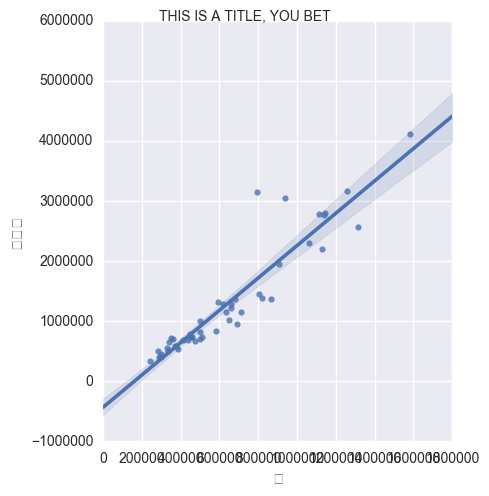

In [27]:
import pandas as pd
import seaborn as sns
%matplotlib inline

dt = pd.read_csv("/Users/01017387/PycharmProjects/test/uploads/2015_hoyu_daisu.csv")
tmp = sns.lmplot(y="乗用車",x="軽",data=dt)
# g.fig.suptitle('THIS IS A TITLE, YOU BET')
# fig = tmp.get_figure()
fig = tmp.fig
fig.suptitle('THIS IS A TITLE, YOU BET')
fig.savefig("test.png")

In [26]:
import matplotlib as mpl
print(mpl.matplotlib_fname())

/Users/01017387/anaconda/lib/python3.5/site-packages/matplotlib/mpl-data/matplotlibrc
